# Daily Stock Alerts based on Technical Indicators 
* Load data
* Count of tickers by Sector
* Sum of weights (should equal 1)

TO DO's:
* Use historical price to track historical weights
* Look into what the sp500_index.csv shows

In [1]:
!pip -q install yfinance
import yfinance as yf
import pandas as pd 
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 

import warnings
warnings.filterwarnings('ignore')

def get_etf_hist(ticker):
    data = yf.Ticker(ticker).history(period="max")
    return data

def is_ranging(stock):
  data = yf.Ticker(stock).history(period="max")

  # Calculate the 50 and 200 day simple moving averages
  sma_50 = data['Close'].rolling(window=50).mean()
  sma_200 = data['Close'].rolling(window=200).mean()

  # create basic trending rule, [-1] is often used to get most recent row in dataframe
  if sma_50[-1] < data['Close'][-1] < sma_200[-1]:
    return True
  else:
    return False

stock_hist = pd.read_csv('/kaggle/input/sp-500-stocks/sp500_stocks.csv')
stocks = pd.read_csv('/kaggle/input/sp-500-stocks/sp500_companies.csv')
stock_list = stocks['Symbol'].to_list()

print(stocks.groupby('Sector').size())
print('Sum of all stock weights: ' +str(stocks['Weight'].sum()))

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 8.0.0 which is incompatible.
Sector
Basic Materials           22
Communication Services    22
Consumer Cyclical         57
Consumer Defensive        36
Energy                    23
Financial Services        68
Healthcare                64
Industrials               71
Real Estate               31
Technology                71
Utilities                 30
dtype: int64
Sum of all stock weights: 0.9999999999999756


## Functions and Data Structures for Stock data
* Enter the S&P500 stock tickers that you wish to regularly track in the cell labeled **Your Stocks**
* They can be in any order as long as they are valid tickers

### My Stocks

In [2]:
my_stocks = [
'ACN',
'AMZN',
'AAPL',
'BAC',
'BBY',
'COF',
'COST',
'DIS',
'EQIX',
'GOOG',
'GS',
'HAL',
'HCA',
'LUMN',
'MSFT',
'NFLX',
'NVDA',
'PG',
'PM',
'PYPL',
'SIVB',
'TSLA'    
]

In [3]:
#Create stock list dictionary
def stock_list_to_dict(ms_list):
    ms_dict = {}
    for s in ms_list:
        ms_dict[s] = {'price_history': None}
    
    return ms_dict

my_stocks_dict = stock_list_to_dict(my_stocks)

for s in my_stocks_dict.keys():
    print(s)
    my_stocks_dict[s]['price_history'] = stock_hist[stock_hist['Symbol'] == s]

ACN
AMZN
AAPL
BAC
BBY
COF
COST
DIS
EQIX
GOOG
GS
HAL
HCA
LUMN
MSFT
NFLX
NVDA
PG
PM
PYPL
SIVB
TSLA


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 
import plotly.express as px

def bollinger(df):
    df['SMA'] = df.Close.rolling(window = 20).mean()
    df['stddev'] = df.Close.rolling(window = 20).std()
    df['Upper'] = df.SMA + 2 * df.stddev
    df['Lower'] = df.SMA - 2 * df.stddev
    df['buysignal'] = np.where(df.Lower > df.Close, True, False)
    df['sellsignal'] = np.where(df.Upper < df.Close, True, False)
    df.dropna(inplace = True)

    return df

def plotter(df, ticker):

    fig, ax = plt.subplots()
    fig.figsize=(20,12)

    ax.plot('Date', 'Close', data=df)

    plt.plot('Date', 'SMA', data=df) 
    plt.plot('Date', 'Upper', data=df) 
    plt.plot('Date', 'Lower', data=df) 
    
    plt.scatter('Date','Close', data=df[df['buysignal'] == True], marker = '^', color = 'g', s = 100) #X axis is date, Y axis is close price
    plt.scatter('Date','Close', data=df[df['sellsignal'] == True], marker = 'v', color = 'r', s = 100) #X axis is date, Y axis is close price
    plt.fill_between('Date','Upper','Lower',data=df,color = 'grey', alpha = 0.2)
    plt.legend(['Price','SMA','Upper','Lower'])
    plt.title('Indicators for ticker: ' + ticker)
    plt.xlabel('Date')
    plt.ylabel('Price')
    
    plt.savefig(ticker + '.png')
    plt.show()


class stock_summary:

    def __init__(self, data, start_date):
        df_price_hist = my_stocks_dict[data]['price_history'][['Date','Close']]
        if(~df_price_hist.empty):
            df_price_hist['Date'] = pd.to_datetime(df_price_hist['Date'], utc=True)
            df_price_hist = bollinger(df_price_hist[df_price_hist['Date'] >= start_date])
            df_price_hist.reset_index(inplace=True,drop=True)
            self.df = df_price_hist
            self.prices = df_price_hist['Close']
            self.ticker = str(data)
        else:
            self.df = pd.DataFrame()

    def calculate_returns(self):
        returns = []
        for i in range(1, len(self.prices)):
            current_return = (self.prices[i] - self.prices[i-1]) / self.prices[i-1]
            returns.append(current_return)
        return returns
    
    def plot_history(self):

        if(self.df.empty == False):
            sns.set()
            sns.set(rc={'figure.figsize':(15,10)})
            plotter(self.df, self.ticker)  
        else:
            pass

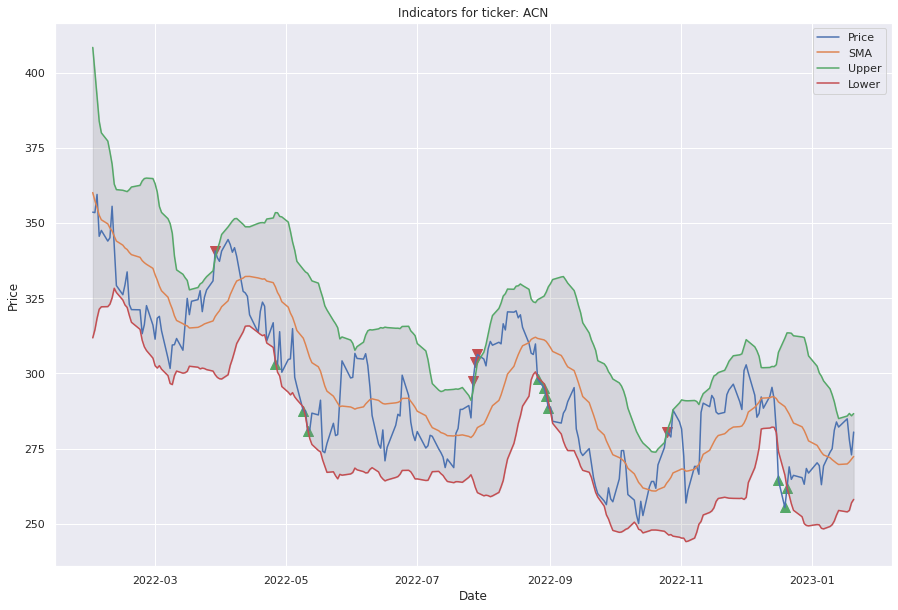

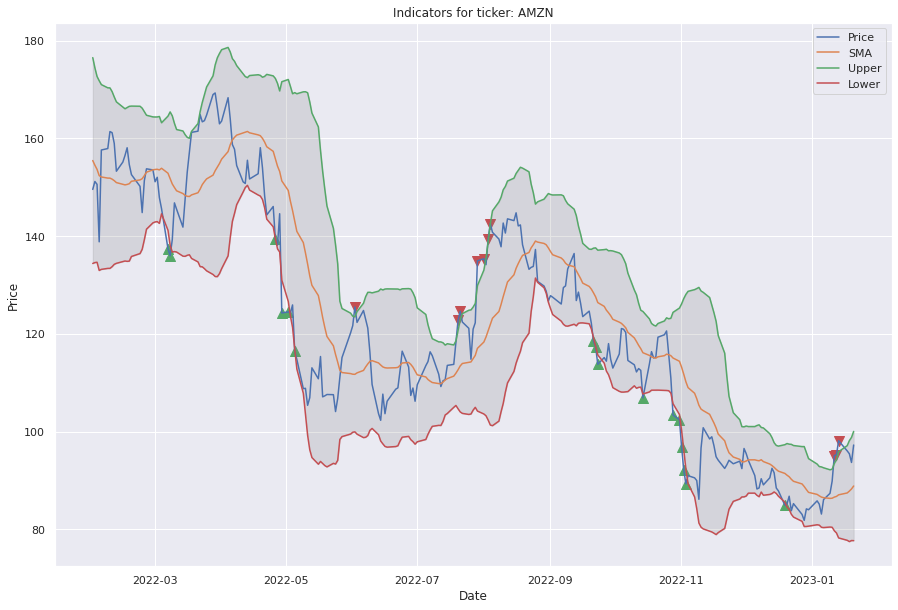

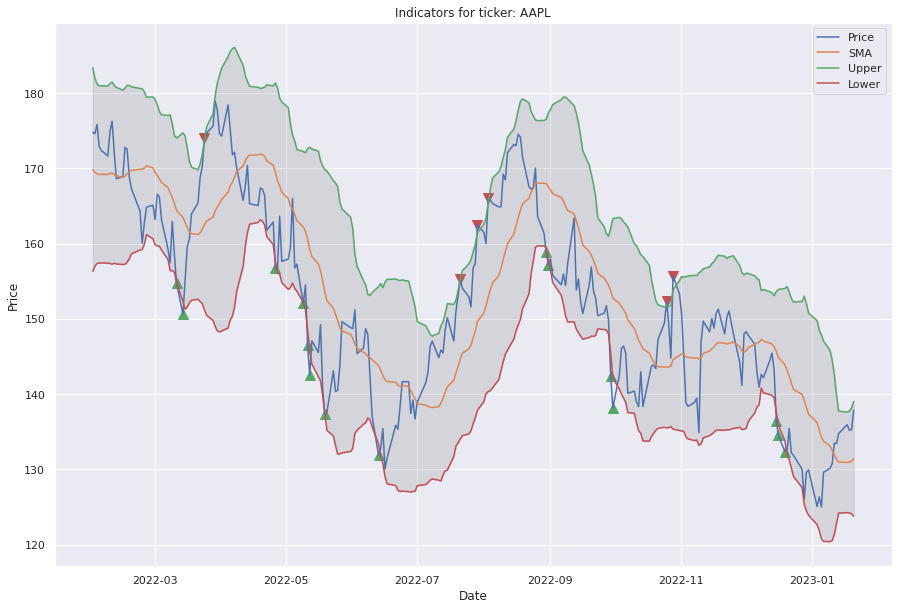

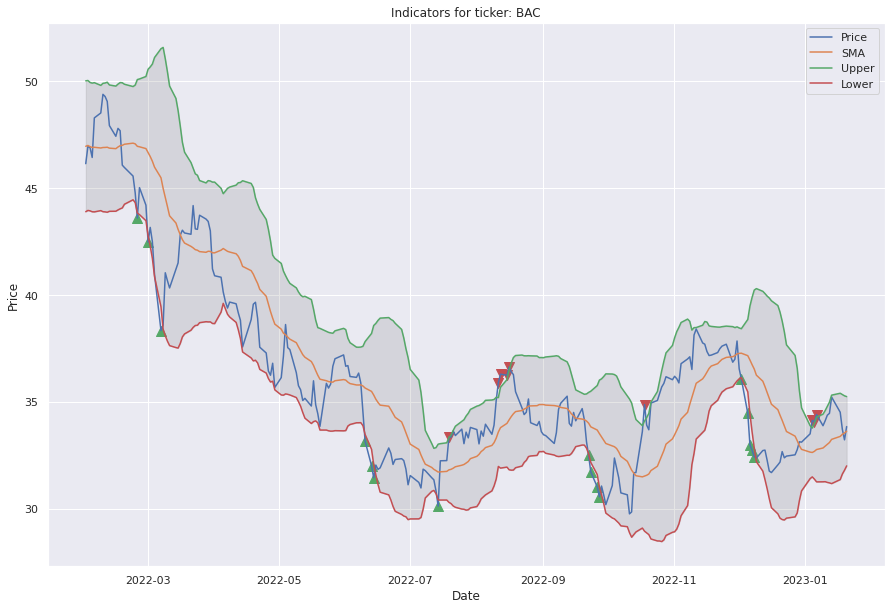

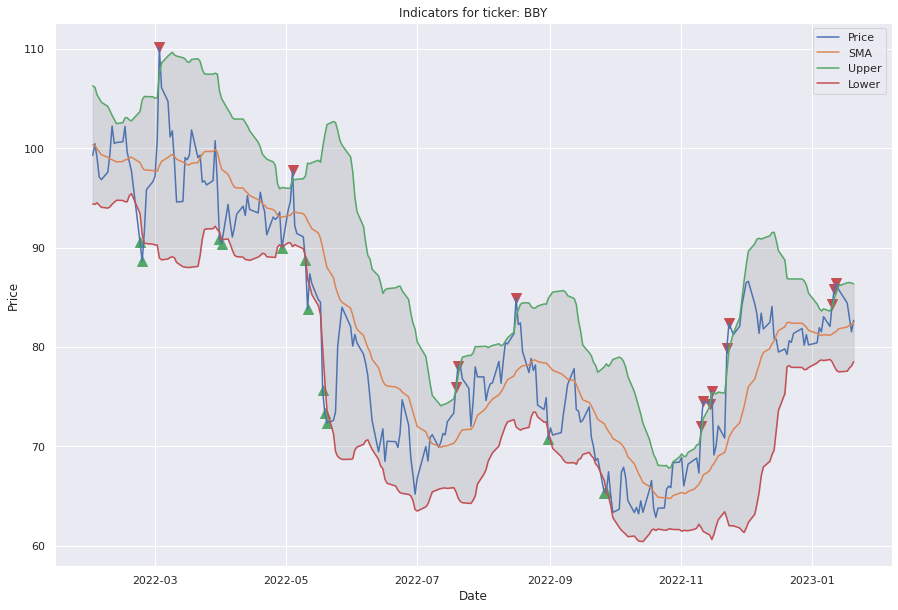

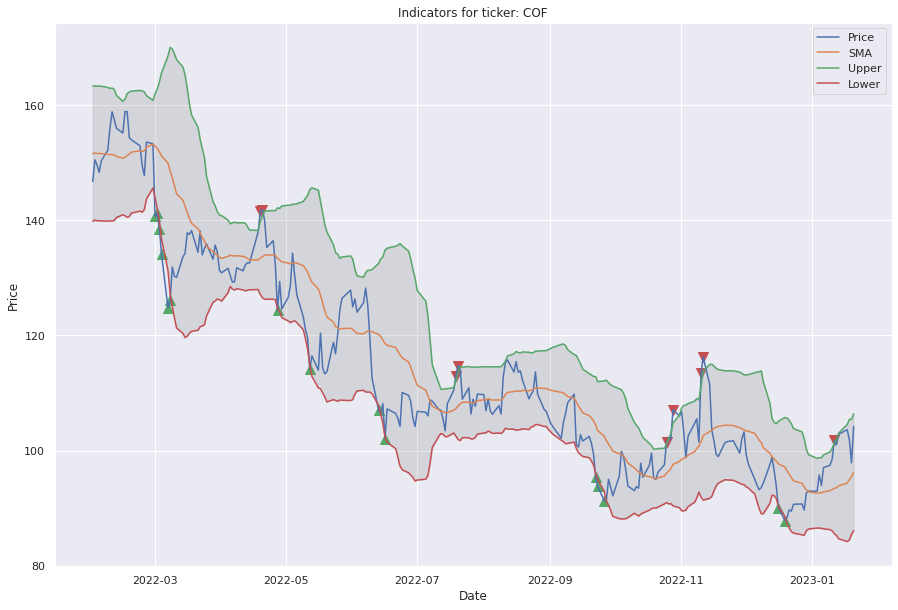

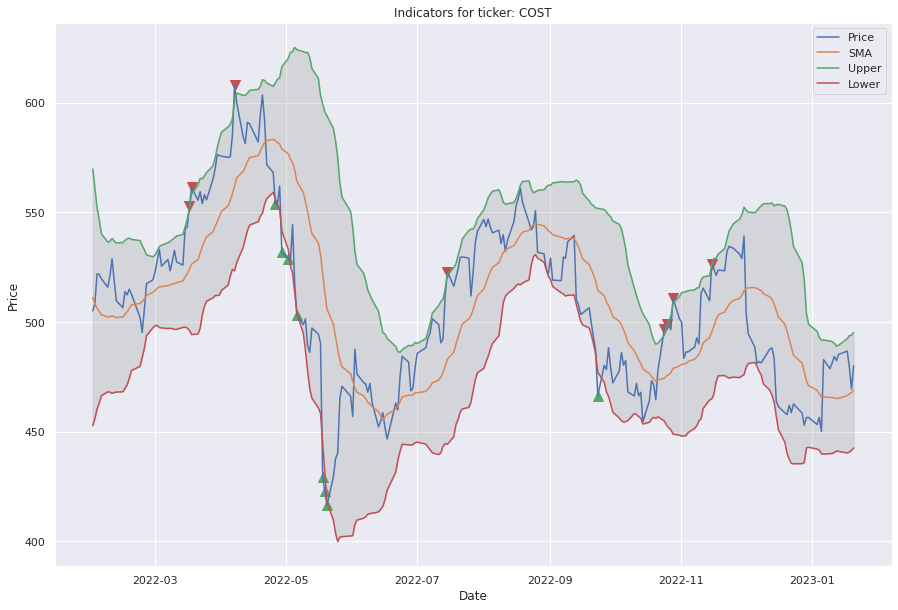

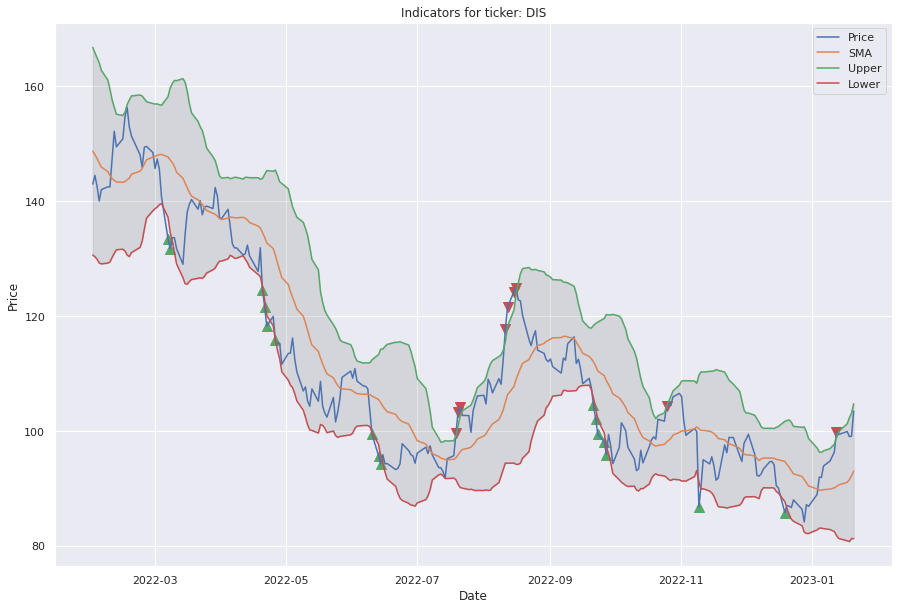

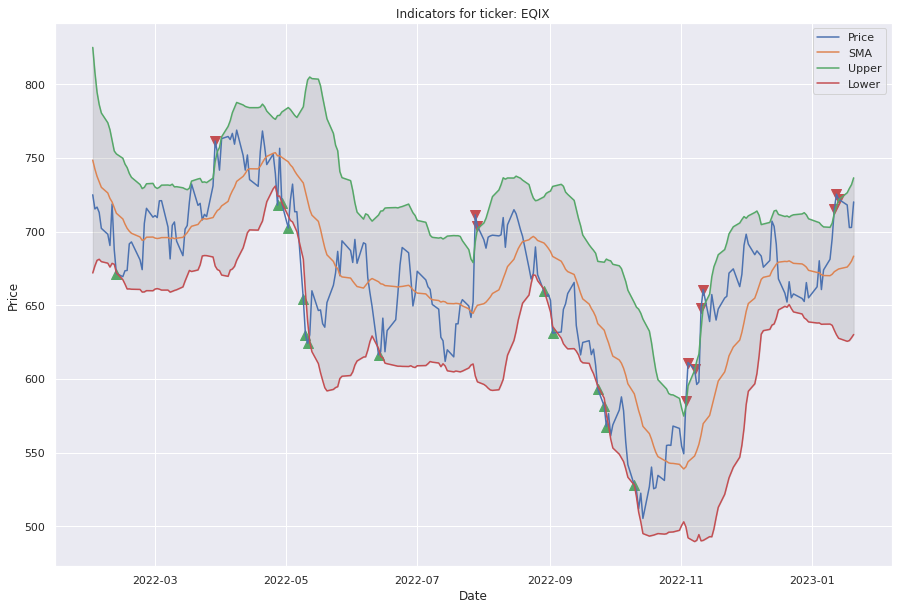

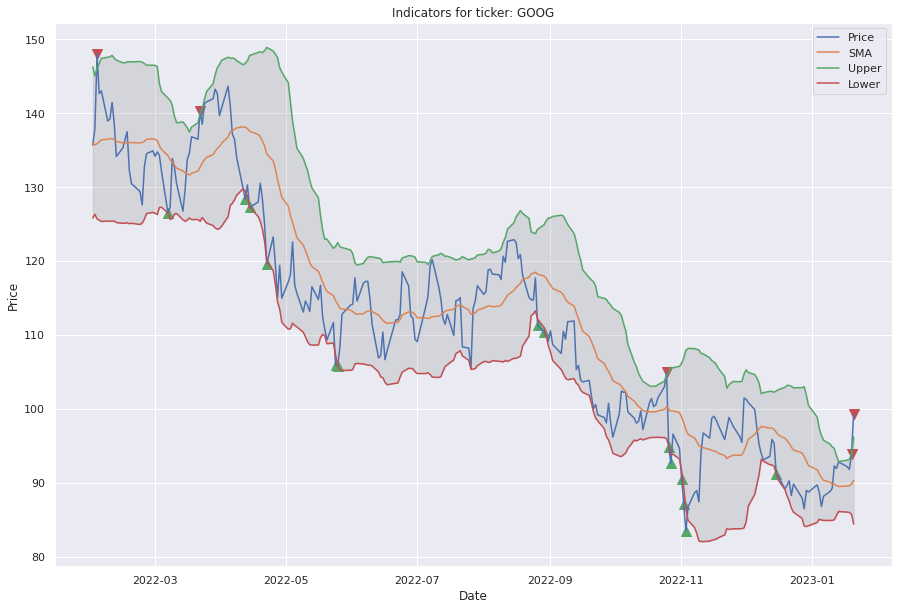

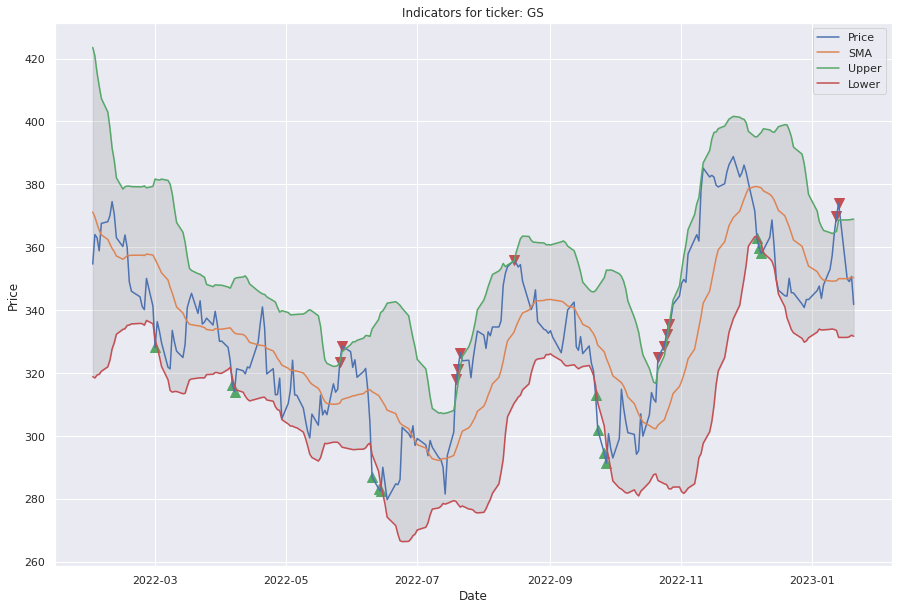

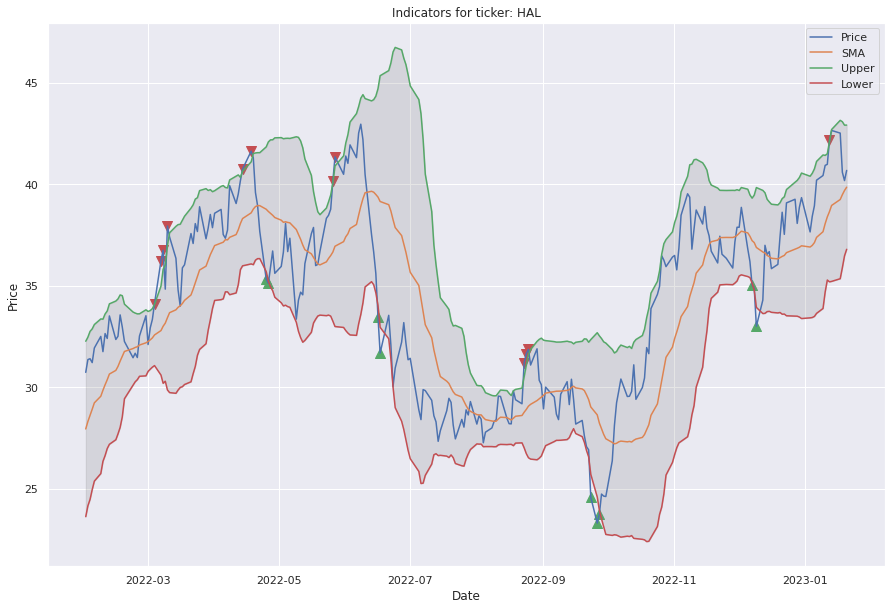

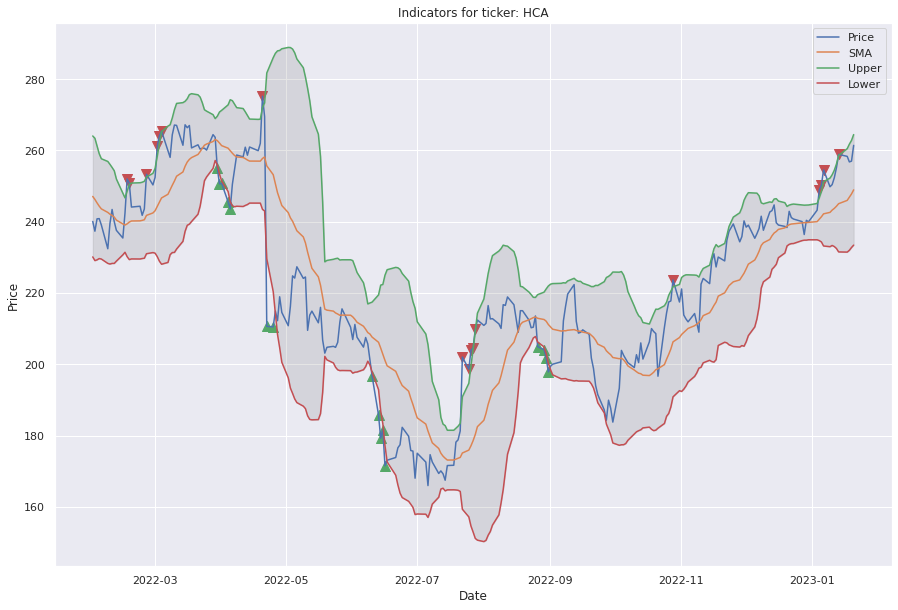

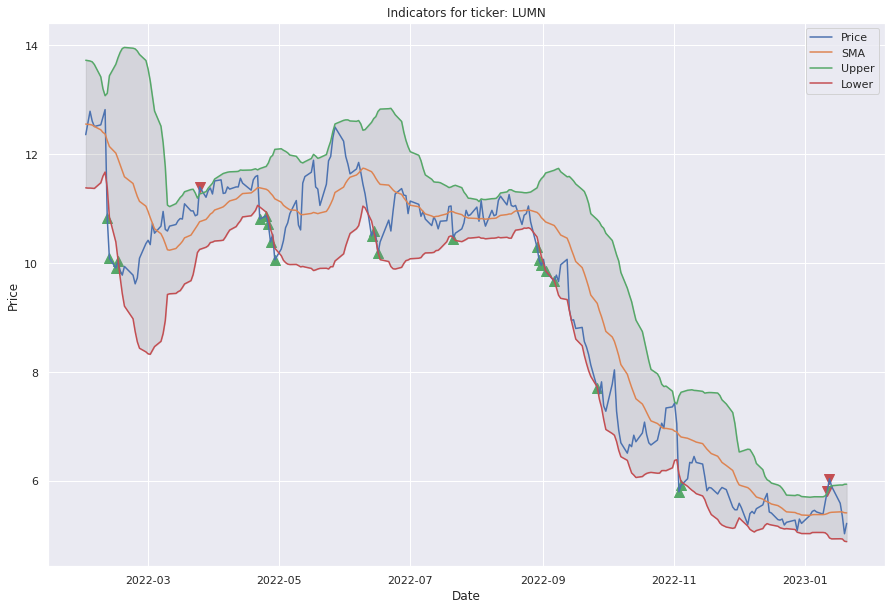

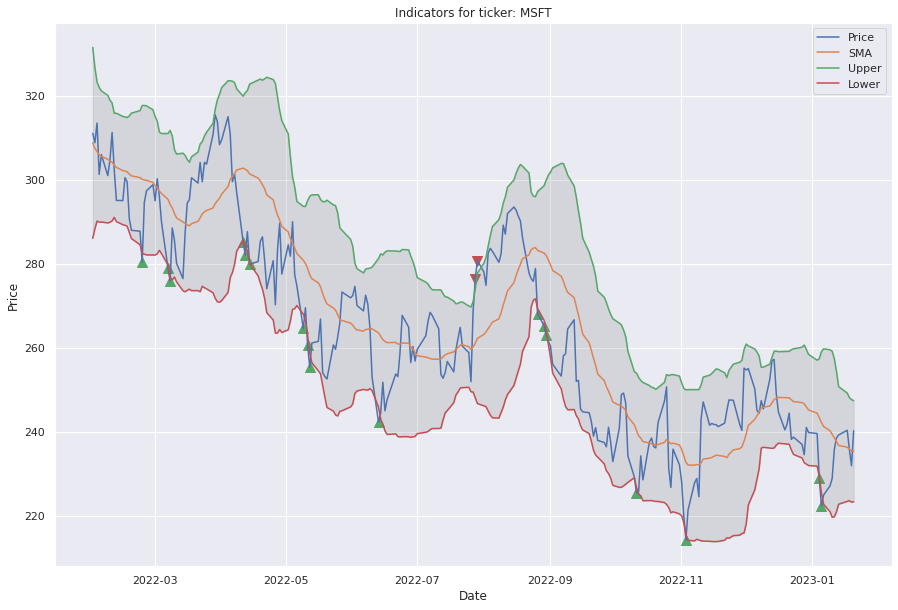

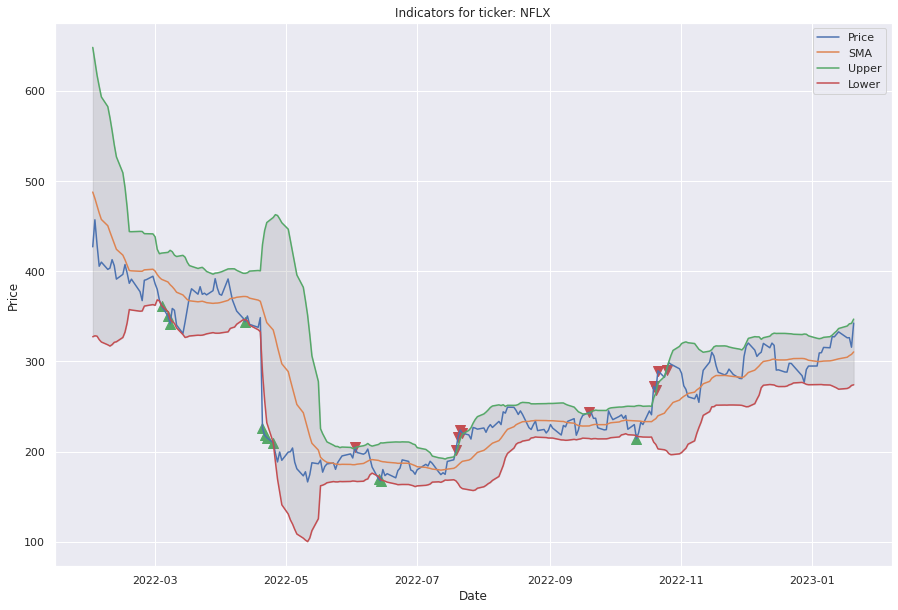

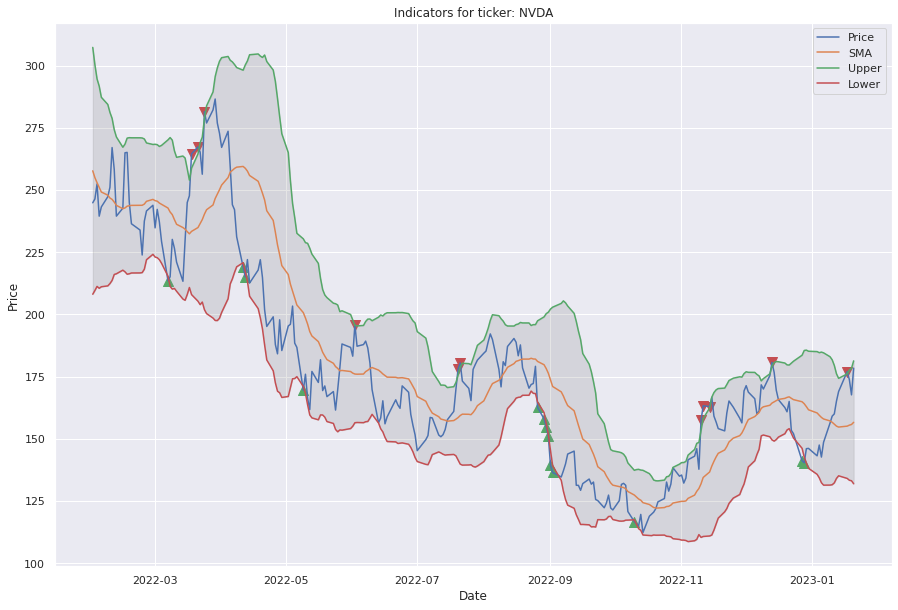

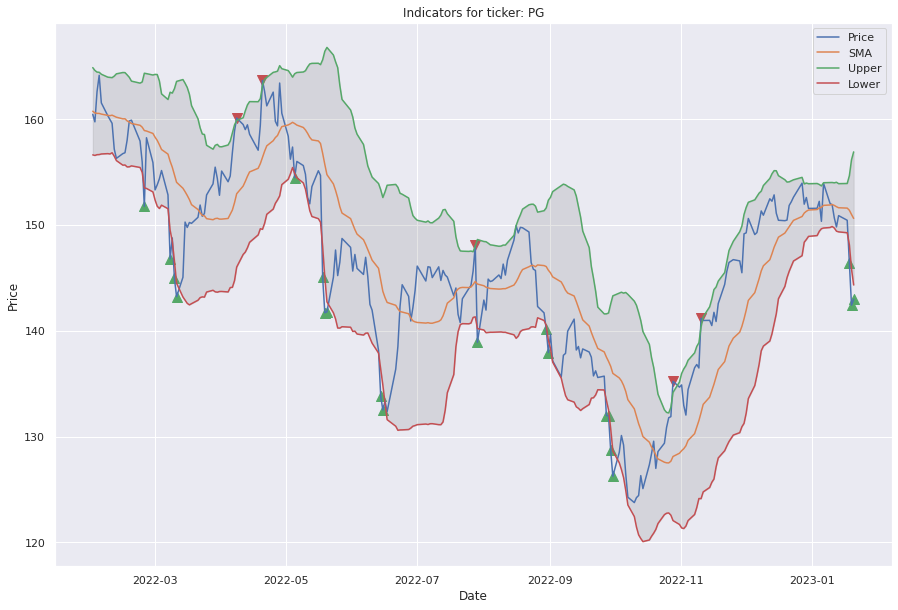

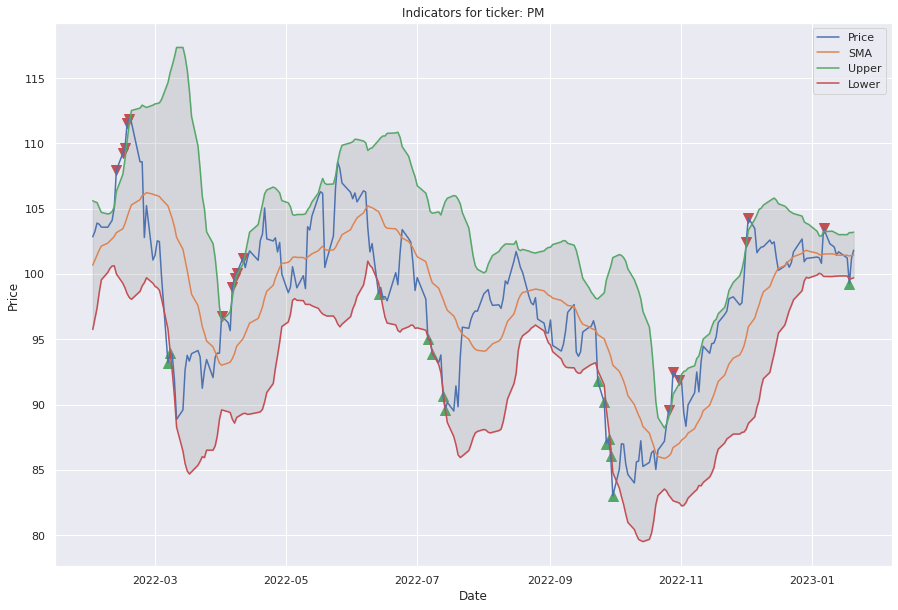

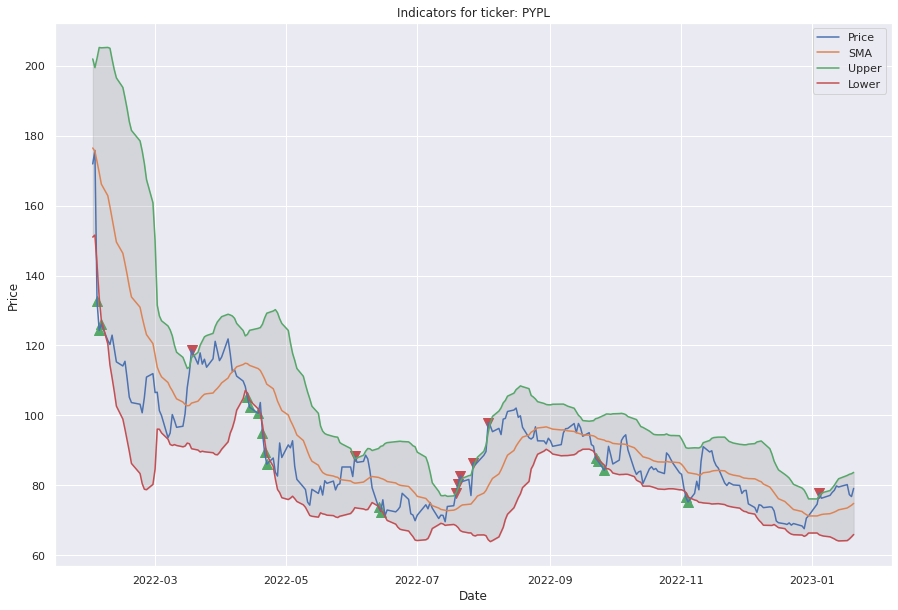

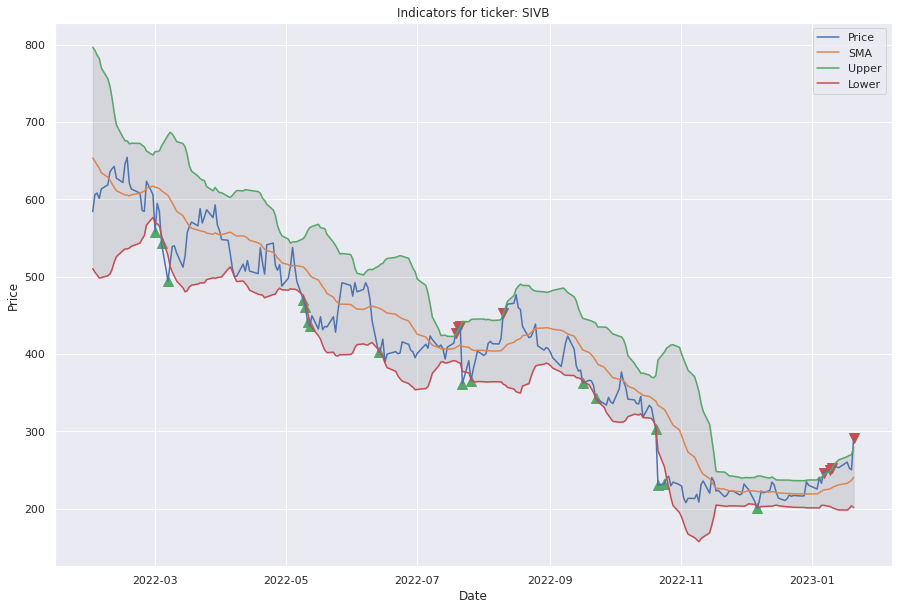

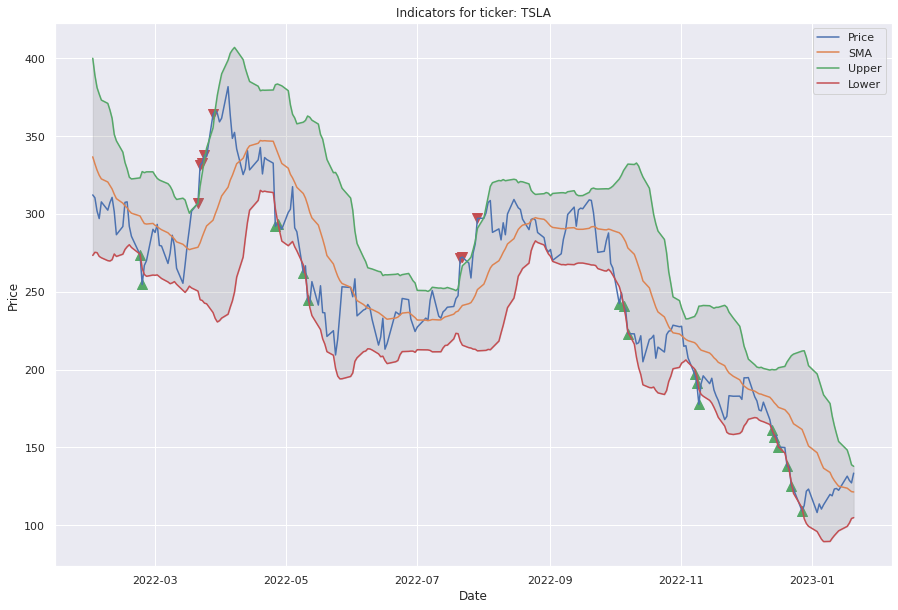

In [5]:
for s in my_stocks_dict.keys():
    try:
        my_stocks_dict[s]['chart'] = stock_summary(s, '2022-01-01').plot_history()
    except:
        pass

[*********************100%***********************]  1 of 1 completed


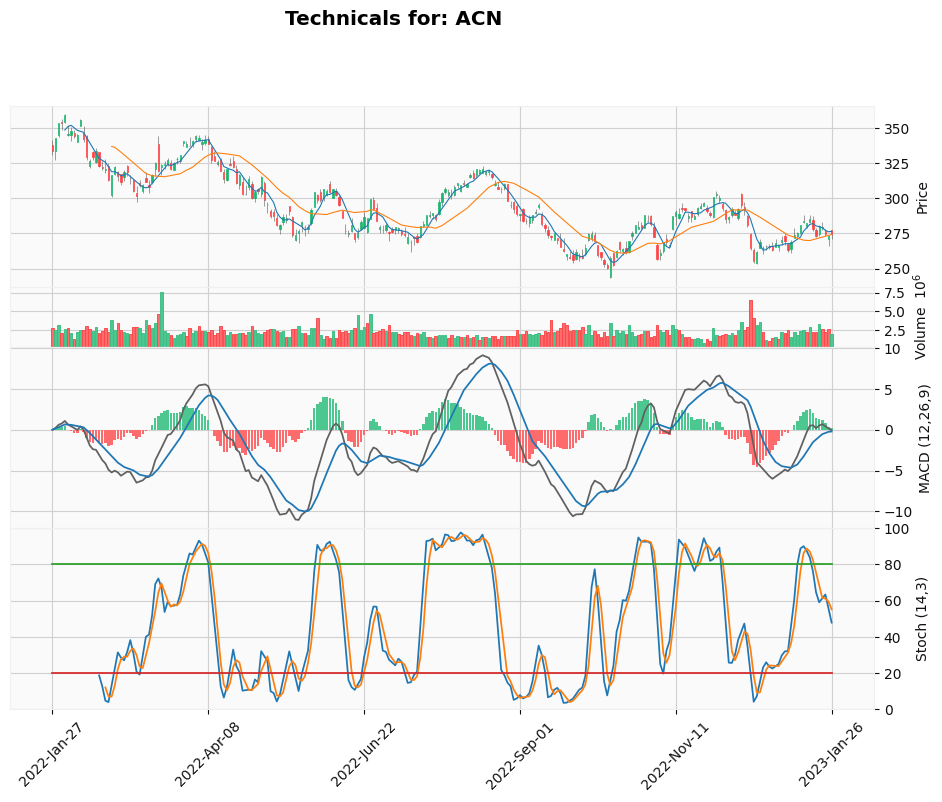

In [6]:
!pip -q install mplfinance
import mplfinance as mpf

ticker = 'ACN'
df = yf.download(ticker, period='12mo')


# Stochastic
def Stochastic(df, window, smooth_window):
    stochastic = pd.DataFrame()
    stochastic['%K'] = ((df['Close'] - df['Low'].rolling(window).min()) \
                        / (df['High'].rolling(window).max() - df['Low'].rolling(window).min())) * 100
    stochastic['%D'] = stochastic['%K'].rolling(smooth_window).mean()
    stochastic['%SD'] = stochastic['%D'].rolling(smooth_window).mean()
    stochastic['UL'] = 80
    stochastic['DL'] = 20
    return stochastic

# Add MACD as subplot
def MACD(df, window_slow, window_fast, window_signal):
    macd = pd.DataFrame()
    macd['ema_slow'] = df['Close'].ewm(span=window_slow).mean()
    macd['ema_fast'] = df['Close'].ewm(span=window_fast).mean()
    macd['macd'] = macd['ema_slow'] - macd['ema_fast']
    macd['signal'] = macd['macd'].ewm(span=window_signal).mean()
    macd['diff'] = macd['macd'] - macd['signal']
    macd['bar_positive'] = macd['diff'].map(lambda x: x if x > 0 else 0)
    macd['bar_negative'] = macd['diff'].map(lambda x: x if x < 0 else 0)
    return macd

macd = MACD(df, 12, 26, 9)
stochastic = Stochastic(df, 14, 3)
plots  = [
    mpf.make_addplot((macd['macd']), color='#606060', panel=2, ylabel='MACD (12,26,9)', secondary_y=False),
    mpf.make_addplot((macd['signal']), color='#1f77b4', panel=2, secondary_y=False),
    mpf.make_addplot((macd['bar_positive']), type='bar', color='#4dc790', panel=2),
    mpf.make_addplot((macd['bar_negative']), type='bar', color='#fd6b6c', panel=2),
    mpf.make_addplot((stochastic[['%D', '%SD', 'UL', 'DL']]), ylim=[0, 100], panel=3, ylabel='Stoch (14,3)')
]
mpf.plot(df, title='Technicals for: ' + ticker ,type='candle', style='yahoo', mav=(5,20), volume=True, addplot=plots, panel_ratios=(3,1,3,3), figscale=1.5)


# Code for emailing technicals digest

In [7]:
!pip -q install django
from django.core.mail import EmailMessage
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText


# Create a "related" message container that will hold the HTML 
# message and the image. These are "related" (not "alternative")
# because they are different, unique parts of the HTML message,
# not alternative (html vs. plain text) views of the same content.
html_part = MIMEMultipart(_subtype='related')

# Create the body with HTML. Note that the image, since it is inline, is 
# referenced with the URL cid:myimage... you should take care to make
# "myimage" unique
body = MIMEText('<p>Hello <img src="cid:myimage" /></p>', _subtype='html')
html_part.attach(body)

# Now create the MIME container for the image
# Load the image you want to send as bytes
for s in my_stocks:
    img_data = open('/kaggle/working/' + s + '.png', 'rb').read()
#    img = MIMEImage(img_data, 'jpeg')
    img = MIMEImage(img_data, 'png')
                
    img.add_header('Content-Id', '<img' + s +'>')  # angle brackets are important
    img.add_header("Content-Disposition", "inline", filename='<img' + s +'>')
    html_part.attach(img)

# Configure and send an EmailMessage
# Note we are passing None for the body (the 2nd parameter). You could pass plain text
# to create an alternative part for this message
# msg = EmailMessage('Subject Line', None, 'foo@bar.com', ['bar@foo.com'])
# msg.attach(html_part) # Attach the raw MIMEBase descendant. This is a public method on EmailMessage


In [8]:
# body = MIMEText('<p>Hello <img src="cid:myimage" /></p>', _subtype='html')
# html_part.attach(body)

# img = MIMEImage(img_data, 'jpeg')
# img.add_header('Content-Id', '<myimage>')  # angle brackets are important
# img.add_header("Content-Disposition", "inline", filename="myimage") # David Hess recommended this edit
# html_part.attach(img)



In [9]:
import smtplib
import getpass
from email.message import EmailMessage
 
# try:
#     p = getpass.getpass()
# except Exception as error:
#     print('ERROR', error)
# else:
#     print('Password entered:', p)

p = 'dxfzcggnmulqxwfi'    
# set your email and password
# please use App Password
email_address = "dlapushin@gmail.com"
email_password = p
# create email
msg = EmailMessage()
msg['Subject'] = "Daily Stock Alerts"
msg['From'] = email_address
msg['To'] = "dlapushin@gmail.com"

# for s in my_stocks:
#     img_data = open('/kaggle/working/' + s + '.png', 'rb').read()
# #    img = MIMEImage(img_data, 'jpeg')
#     img = MIMEImage(img_data, 'png')

# file = '/kaggle/working/output/stock_alerts.html'

# with open(file, 'rb') as fp:
#     img_data = fp.read()
#     msg.add_attachment(html_part)

msg.add_attachment(html_part)
    
# send email
with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
    smtp.login(email_address, email_password)
    smtp.send_message(msg)

In [10]:
# import matplotlib.pyplot as plt
# import base64
# from io import BytesIO

# tmpfile = BytesIO()
# fig.savefig(tmpfile, format='png')
# encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

# html = 'Some html head' + '<img src=\'data:image/png;base64,{}\'>'.format(encoded) + 'Some more html'

# with open('test.html','w') as f:
#     f.write(html)

In [11]:
# !pip -q install yfinance
# import yfinance as yf

# msft = yf.Ticker("MSFT")

# # get stock info
# msft.info

# # get historical market data
# hist = msft.history(period="max")

# # show meta information about the history (requires history() to be called first)
# msft.history_metadata

# # show actions (dividends, splits, capital gains)
# msft.actions

# # show dividends
# msft.dividends

# # show splits
# msft.splits


# # show capital gains (for mutual funds & etfs)
# msft.capital_gains

# # show share count
# msft.shares
# msft.get_shares_full()
# msft.get_shares_full().at_time